In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook

G = 6.67430e-11 # м^3 кг^-1 с^-2

In [2]:
class Star:
    def __init__(self, mass: float, R: float = 0):
        """
        Создание объекта звезды.
        
        Parameters
        ----------
        mass : float
            Масса звезды.
        R : float
            Радиус звезды.
        """
        self.M = mass
        self.X = 0.
        self.R = R
        self.alive = True

In [3]:
class CosmicBody:
    def __init__(self, mass: float, vec_v: list, vec_P: list, R: float = 0):
        """
        Создание объекта космического тела.
        
        Parameters
        ----------
        mass : float
            Масса тела.
        vec_v : list
            Вектор скорости тела.
        vec_P : list
            Вектор положения тела.
        R : float
            Радиус тела.
        """
        self.M = mass
        self.X = np.array(vec_P, dtype=np.float64)
        self.V = np.array(vec_v, dtype=np.float64)
        self.A = np.zeros_like(self.V, dtype=np.float64)
        self.R = R
        self.alive = True
        
    def gravitate(self, bodies: list):
        """
        Расчет ускорения тела.
        
        Parameters
        ----------
        bodies : list[CosmicBody]
            Список тел, с которыми нужно расчитать взаимодействие.
        """
        if not self.alive:
            return
        self.A = 0.
        for body in bodies:
            r = body.X - self.X
            distance = np.linalg.norm(r)
            if distance < self.R + body.R:
                self.destroy()
            self.A += G * body.M * r / distance ** 3
            
    def step(self, dt: float):
        """
        Обновление координат и скоростей по расчитанным ускорениям.
        
        Parameters
        ----------
        dt : float
            Шаг по времени.
        """
        if not self.alive:
            return
        self.X += self.V * dt + self.A * dt ** 2 / 2
        self.V += self.A * dt
        
    def destroy(self):
        """
        Уничтожение тела в результате столкновения.
        """
        self.alive = False

In [4]:
class System:
    def __init__(self, star: Star, bodies: list[CosmicBody], dt: float = 1e-3):
        """
        Создание объекта системы космических тел.
        
        Parameters
        ----------
        star : Star
            Звезда в системе.
        bodies : list[CosmicBody]
            Космические тела в системе.
        dt : float
            Шаг расчета ускорений.
        """
        self.star = star
        self.bodies = bodies
        self.t = [0.]
        self.dt = dt
        self.trajectories = [[body.X.copy()] for body in self.bodies]
        
    def save_state(self):
        """
        Сохранение положений тел.
        """
        for i, body in enumerate(self.bodies):
            self.trajectories[i].append(body.X.copy())
        
    def build_trajectories(self, T: float):
        """
        Расчет траекторий движения тел.
        
        Parameters
        ----------
        T : float
            Конечное время, до которого расчитываются траектории в системе.
        """
        self.t = [self.t[0]]
        while self.t[-1] < T:
            bodies = [body for body in self.bodies if body.alive]
            if len(bodies) == 0:
                print("All bodies were destroyed")
                break
            for i, body in enumerate(bodies):
                body.gravitate([self.star, *self.bodies[:i], *self.bodies[i+1:]])
            for body in self.bodies:
                body.step(self.dt)
            self.save_state()
            self.t.append(self.t[-1] + self.dt)
        else:
            print("All trajectories were calculated")
            
    def draw2D(self):
        """
        Визуализация траекторий объектов для двумерного случая.
        """
        fig, ax = plt.subplots()
        ax.set_aspect("equal")
        
        lines = []
        bodies = []
        for _ in self.trajectories:
            lines.append(ax.plot([], [], 'b')[0])
            bodies.append(ax.plot([], [], 'bo')[0])
        trajectories = np.array(self.trajectories)
        
        max_ = trajectories.max() * 1.1
        ax.axis([-max_, max_, -max_, max_])
        ax.plot(0, 0, 'ro')
        
        def animate(i):
            for line, body, trajectory in zip(lines, bodies, trajectories):
                line.set_data(trajectory[:i, 0], trajectory[:i, 1])
                body.set_data(trajectory[i, 0], trajectory[i, 1])

        return FuncAnimation(fig, animate, frames=len(self.t), interval=1)
    
    def draw3D(self):
        """
        Визуализация траекторий объектов для трехмерного случая.
        """
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        
        lines = []
        bodies = []
        for _ in self.trajectories:
            lines.append(ax.plot([], [], [], 'b')[0])
            bodies.append(ax.plot([], [], [], 'bo')[0])

        trajectories = np.array(self.trajectories)
        if trajectories.shape[-1] < 3:
            tmp = np.zeros((*trajectories.shape[:-1], 3))
            tmp[:, :, :trajectories.shape[-1]] = trajectories
            trajectories = tmp
        
        max_ = trajectories.max() * 1.1
        ax.axes.set_xlim3d(-max_, max_)
        ax.axes.set_ylim3d(-max_, max_)
        ax.axes.set_zlim3d(-max_, max_)
        ax.plot(0, 0, 0, 'ro')
        
        def animate(i):
            for line, body, trajectory in zip(lines, bodies, trajectories):
                line.set_data(trajectory[:i, 0], trajectory[:i, 1])
                line.set_3d_properties(trajectory[:i, 2])
                body.set_data(trajectory[i, 0], trajectory[i, 1])
                body.set_3d_properties(trajectory[i, 2])

        return FuncAnimation(fig, animate, frames=len(self.t), interval=1)

All trajectories were calculated


<IPython.core.display.Javascript object>


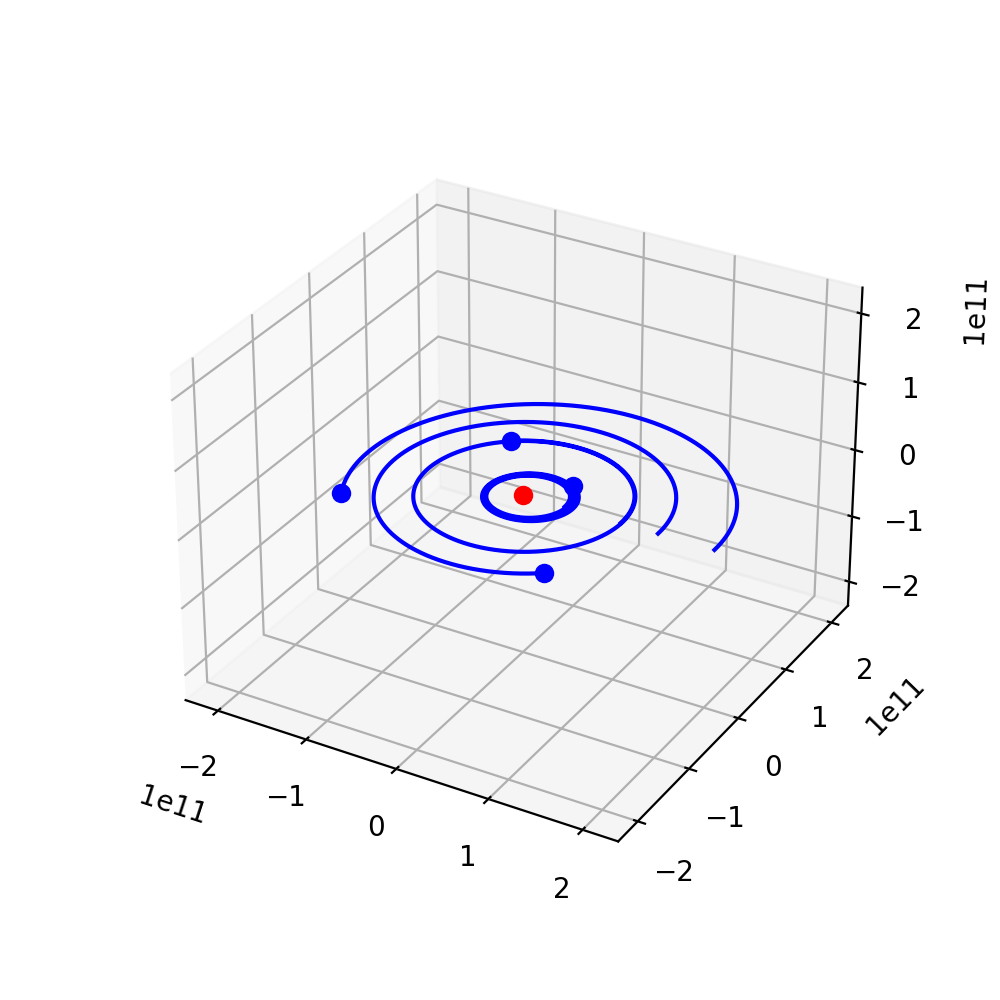

In [5]:
system = System(
    Star(mass=1.99e30, R=6.95e8), 
    [
        CosmicBody(3.33e23, [0, 49.36e3], [4.6e10,  0], R=2.44e6), # Меркурий
        CosmicBody(4.87e24, [0, 35e3   ], [1.07e11, 1], R=6.05e6), # Венера
        CosmicBody(5.97e24, [0, 29.8e3 ], [1.47e11, 1], R=6.4e6), # Земля
        CosmicBody(6.42e23, [0, 24.13e3], [2.07e11, 0], R=3.4e6) # Марс
    ],
    dt=60 * 60 # one hour
)

system.build_trajectories(365 * 24 * 60 * 60) # one year
system.draw3D()